In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn

In [ ]:
import os
import cv2
import math
import pickle
import numpy as np
from PIL import Image
from random import choice
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers, Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Dropout, Flatten, Input, AveragePooling2D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, TerminateOnNaN, LambdaCallback

from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# from mtcnn.mtcnn import MTCNN

### Reading TFrecord

In [ ]:
# function to parse single tfrecord example
def _parse_tfrecord():
    def parse_tfrecord(tfrecord):
        features = {'image/source_id': tf.io.FixedLenFeature([], tf.int64),
                    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
                    'image/encoded': tf.io.FixedLenFeature([], tf.string)}
        x = tf.io.parse_single_example(tfrecord, features)
        x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)

        #         y_label = tf.cast(x['image/source_id'], tf.int64)
        y_train = tf.one_hot(x['image/source_id'], 4250)
        # y_train = x['image/source_id']
        # filename = x['image/filename']

        x_train = _transform_images()(x_train)
        return (x_train, y_train)

    return parse_tfrecord

# function to do some data augmentation
def _transform_images():
    def transform_images(x_train):
        # x_train = tf.image.resize(x_train, (170, 170))
        # x_train = tf.image.random_crop(x_train, (160, 160, 3))
        x_train = tf.image.convert_image_dtype(x_train, dtype=tf.float32, saturate=False)
        x_train = tf.image.random_flip_left_right(x_train)
        x_train = tf.image.random_saturation(x_train, 0.6, 1.4)
        x_train = tf.image.random_brightness(x_train, 0.4)
        mean = tf.math.reduce_mean(x_train)
        std = tf.math.reduce_std(x_train)
        x_train = tf.math.subtract(x_train, mean)
        x_train = tf.math.divide(x_train, std)
        #         x_train = x_train / 255
        return x_train

    return transform_images

# reading tfrecord
def load_tfrecord_dataset(tfrecord_name, batch_size, repeat=False, shuffle=False, buffer_size=100000):
    """load dataset from tfrecord"""
    # dataset_len = int(sum(1 for _ in tf.data.TFRecordDataset(tfrecord_name)))

    # train_size = round(0.85 * int(dataset_len / batch_size))
    # val_size = round(0.15 * int(dataset_len / batch_size))

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    # raw_dataset = raw_dataset.repeat()

    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    if repeat:
        dataset = dataset.repeat()

    # train_dataset = dataset.take(train_size)
    # val_dataset = dataset.skip(train_size)

    # train_dataset = train_dataset.repeat()
    # val_dataset = val_dataset.repeat()

    return dataset

# Get Data

In [ ]:
train_tfrecord_name = "./celeba_(train)_new.tfrecord"

train_dataset_len = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_name))
print("total number of samples:", train_dataset_len)

train_dataset = load_tfrecord_dataset(train_tfrecord_name, 32, shuffle=True)

print(train_dataset)

total number of samples: 4250
<PrefetchDataset shapes: ((None, None, None, 3), (None, 4250)), types: (tf.float32, tf.float32)>


In [ ]:
test_tfrecord_name = "./celeba_(test)_new.tfrecord"

test_dataset_len = sum(1 for _ in tf.data.TFRecordDataset(test_tfrecord_name))
print("total number of samples:", test_dataset_len)

test_dataset = load_tfrecord_dataset(test_tfrecord_name, 1, shuffle=False)

print(test_dataset)

total number of samples: 76370
<PrefetchDataset shapes: ((None, None, None, 3), (None, 4250)), types: (tf.float32, tf.float32)>


# Training

In [ ]:
emb_shape = 512
w_decay = 1e-4
num_classes = train_dataset_len

# using facenet as the backbone model
model_face = load_model('facenet_keras.h5')

# freeze all layers
for layer in model_face.layers[:]:
    layer.trainable = False

# adding custom layers
last = model_face.output
x = BatchNormalization()(last)
x = Dropout(rate=0.5)(x)
x = Dense(emb_shape, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(w_decay))(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation = "softmax", kernel_regularizer=regularizers.l2(w_decay))(x)

model = Model(inputs=model_face.input, outputs=x, name="model_1")

In [ ]:
lr = 0.005
min_lr = 0.0001
momentum = 0.5
total_epochs = 200

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_dataset.repeat(), epochs=total_epochs, verbose=1, steps_per_epoch=250, callbacks=[callback])

Epoch 1/200
250/250 [==============================] - 51s 55ms/step - loss: 8.6479 - accuracy: 1.0653e-04
Epoch 2/200
250/250 [==============================] - 13s 53ms/step - loss: 8.5291 - accuracy: 7.0335e-04
Epoch 3/200
250/250 [==============================] - 13s 54ms/step - loss: 8.4239 - accuracy: 0.0011
Epoch 4/200
250/250 [==============================] - 14s 55ms/step - loss: 8.2886 - accuracy: 0.0020
Epoch 5/200
250/250 [==============================] - 14s 55ms/step - loss: 8.1752 - accuracy: 0.0050
Epoch 6/200
250/250 [==============================] - 14s 54ms/step - loss: 8.0660 - accuracy: 0.0098
Epoch 7/200
250/250 [==============================] - 13s 54ms/step - loss: 7.9385 - accuracy: 0.0213
Epoch 8/200
250/250 [==============================] - 13s 54ms/step - loss: 7.8082 - accuracy: 0.0359
Epoch 9/200
250/250 [==============================] - 14s 54ms/step - loss: 7.6965 - accuracy: 0.0510
Epoch 10/200
250/250 [==============================] - 14s 55ms/

In [ ]:
model.save("my_model_new.h5")

In [ ]:
model = tf.keras.models.load_model('my_model(size20)_tfrecord_latest.h5')

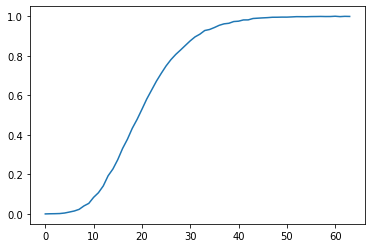

In [ ]:
plt.plot(history.history["accuracy"])

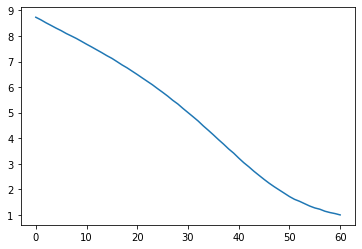

In [ ]:
plt.plot(history.history["loss"])

# Testing


In [ ]:
model.evaluate(test_dataset)

76370/76370 [==============================] - 1201s 16ms/step - loss: 1.8436 - accuracy: 0.9178


[1.8436434268951416, 0.9177818298339844]

In [ ]:
# getting all images with incorrect prediction
images = list()
true_labels = list()
predicted_labels = list()
count = 0

for record in test_dataset:

    (a, b) = (record)

    prediction = model.predict(a)
    predicted_label = np.argmax(prediction, axis=1)
    true_label = np.argmax(b, axis=1)

    if predicted_label[0] != true_label[0]:
        count += 1
        images.append(a[0])
        true_labels.append(true_label[0])
        predicted_labels.append(predicted_label[0])
        # print(count)

print(len(images), len(true_labels), len(predicted_labels))

In [ ]:
# plot all images with incorrect prediction
plt.figure(figsize=(25, 800))

for i in range(len(images[0:2000])):
    plt.subplot(500, 10, i+1)
    plt.axis('off')
    plt.title("T:" + str(true_labels[i]), loc="left", fontsize=8)
    plt.title("P:" + str(predicted_labels[i]), loc="right", fontsize=8)

    img = images[i].numpy()
    minFrom= img.min()
    maxFrom= img.max()
    minTo = 0
    maxTo = 1
    img = minTo + (maxTo - minTo) * ((img - minFrom) / (maxFrom - minFrom))
    plt.imshow(img)